Saving Mall_Customers.csv to Mall_Customers (2).csv
mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open customer-segment

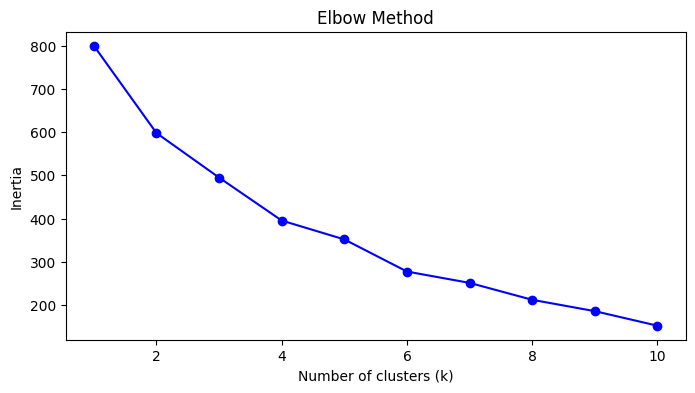

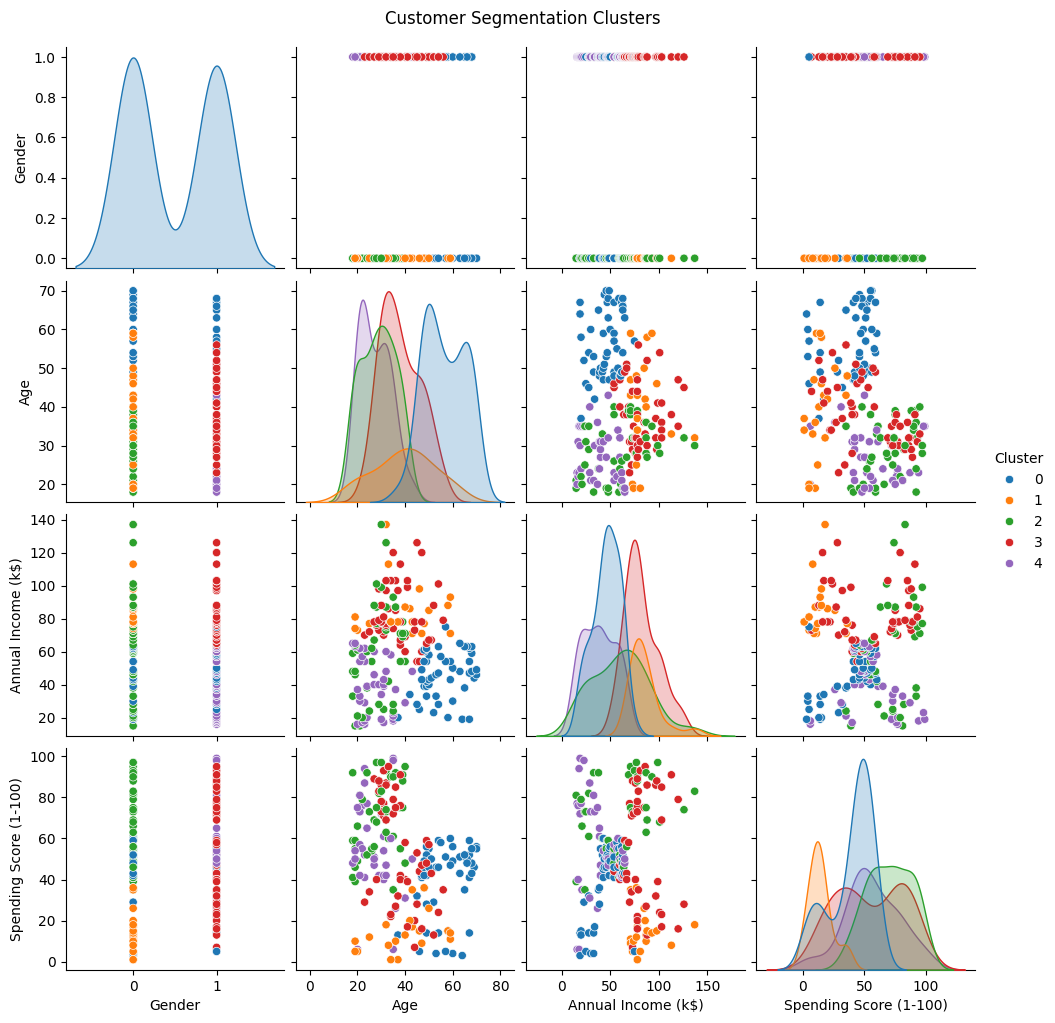

In [25]:
!pip install kaggle
!pip install matplotlib seaborn scikit-learn joblib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib
import os
from google.colab import files

files.upload()

!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d vjchoudhary7/customer-segmentation-tutorial-in-python
!unzip customer-segmentation-tutorial-in-python.zip

df = pd.read_csv("Mall_Customers.csv")
df.drop('CustomerID', axis=1, inplace=True)
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

inertia = []
K_range = range(1, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_data)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

k = 5
final_kmeans = KMeans(n_clusters=k, random_state=42)
df['Cluster'] = final_kmeans.fit_predict(scaled_data)

joblib.dump(final_kmeans, 'kmeans_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
df.to_csv('segmented_customers.csv', index=False)

sns.pairplot(df, hue='Cluster', palette='tab10')
plt.suptitle('Customer Segmentation Clusters', y=1.02)
plt.show()


In [26]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO

st.set_page_config(page_title="Customer Segmentation", layout="wide", initial_sidebar_state="expanded")

@st.cache_resource
def load_model():
    model = joblib.load('kmeans_model.pkl')
    scaler = joblib.load('scaler.pkl')
    return model, scaler

model, scaler = load_model()

st.markdown("""
    <style>
        body {
            background-color: #121212;
            color: #FFFFFF;
        }
        .stApp {
            background-color: #121212;
        }
        h1, h2, h3 {
            color: #00C4FF;
        }
    </style>
""", unsafe_allow_html=True)

st.title("Customer Segmentation Dashboard")
st.markdown("Segment your customers intelligently using K-Means Clustering.")

st.sidebar.header("Upload Data")
uploaded_file = st.sidebar.file_uploader("Upload a CSV file", type=["csv"])

if uploaded_file:
    data = pd.read_csv(uploaded_file)
    original_data = data.copy()

    st.subheader("📊 Uploaded Data Preview")
    st.dataframe(data.head())

    try:
        data.drop('CustomerID', axis=1, inplace=True)
    except:
        pass

    if 'Gender' in data.columns:
        data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})

    scaled_data = scaler.transform(data)
    data['Cluster'] = model.predict(scaled_data)
    original_data['Cluster'] = data['Cluster']

    st.subheader("📌 Clustered Data")
    st.dataframe(original_data)

    st.subheader("📈 Cluster Distribution")
    cluster_counts = data['Cluster'].value_counts().sort_index()
    st.bar_chart(cluster_counts)

    st.subheader("🌀 Visualize Clusters")
    fig, ax = plt.subplots()
    sns.scatterplot(x=data.iloc[:, 2], y=data.iloc[:, 3], hue=data['Cluster'], palette='tab10', ax=ax)
    ax.set_xlabel(data.columns[2])
    ax.set_ylabel(data.columns[3])
    ax.set_title("Customer Segmentation View")
    st.pyplot(fig)
else:
    st.info("Upload a `.csv` file to get started.")

st.markdown("---")
st.markdown("<center>Built by Prajwal • Celebal Internship</center>", unsafe_allow_html=True)


Overwriting app.py
